# 在自定义数据集上微调GIT模型进行图像描述

在本笔记本中，我们将在一个小型图像描述数据集上微调[GIT](https://huggingface.co/docs/transformers/main/en/model_doc/git)（GenerativeImage2Text的缩写）模型。

GIT在编写本文时是最先进的图像/视频描述和问答（QA）模型。

## 环境设置
**环境配置：**

1. MindSpore 2.3.0
2. Mindnlp 0.3.1
3. Python 3.9



**使用华为云 ModelArts 作为AI平台**

在环境搭建部分，使用了AI gallery社区中相关mindnlp项目搭建mindnlp环境的代码。

### 环境配置

配置python3.9环境

In [1]:
%%capture captured_output
!/home/ma-user/anaconda3/bin/conda create -n python-3.9.0 python=3.9.0 -y --override-channels --channel https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/main
!/home/ma-user/anaconda3/envs/python-3.9.0/bin/pip install ipykernel

In [2]:
import json
import os

data = {
   "display_name": "python-3.9.0",
   "env": {
      "PATH": "/home/ma-user/anaconda3/envs/python-3.9.0/bin:/home/ma-user/anaconda3/envs/python-3.7.10/bin:/modelarts/authoring/notebook-conda/bin:/opt/conda/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/home/ma-user/modelarts/ma-cli/bin:/home/ma-user/modelarts/ma-cli/bin"
   },
   "language": "python",
   "argv": [
      "/home/ma-user/anaconda3/envs/python-3.9.0/bin/python",
      "-m",
      "ipykernel",
      "-f",
      "{connection_file}"
   ]
}

if not os.path.exists("/home/ma-user/anaconda3/share/jupyter/kernels/python-3.9.0/"):
    os.mkdir("/home/ma-user/anaconda3/share/jupyter/kernels/python-3.9.0/")

with open('/home/ma-user/anaconda3/share/jupyter/kernels/python-3.9.0/kernel.json', 'w') as f:
    json.dump(data, f, indent=4)

*注：以上代码执行完成后，需点击左上角或右上角将kernel更换为python-3.10.0*

2. 安装mindspore2.3.0，安装指南详见：[MindSpore安装](https://www.mindspore.cn/install/)

3. 安装MindNLP及相关依赖，MindNLP官方仓详见：[MindNLP](https://github.com/mindspore-lab/mindnlp)

In [2]:
!pip install mindspore==2.3.0
!pip install mindnlp==0.3.1
!pip install -q decord
!pip install ipywidgets

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple


## 创建图像描述数据集

接下来，我们将创建一个小型图像描述数据集，该数据集由（图像，文本）对组成。

作为一名足球迷，我简单地访问了几位最著名的足球运动员的维基百科页面，并从各自的页面中获取了带有说明文字的图像。

我们将按照[这里](https://huggingface.co/docs/datasets/main/en/image_dataset#image-captioning)的指南创建一个🤗 Dataset，它允许非常快速的处理。基本上，我们需要在包含图像的文件夹中添加一个metadata.jsonl文件。这个元数据文件包含了每张图像的描述文本。


In [3]:
!git clone https://github.com/wjy4399/Toy_dataset.git

fatal: destination path 'Toy_dataset' already exists and is not an empty directory.


In [4]:
import json
captions = [{"file_name": "ronaldo.jpeg", "text": "Ronaldo with Portugal at the 2018 World Cup"},
{"file_name": "messi.jpeg", "text": "Messi with Argentina at the 2022 FIFA World Cup"},
{"file_name": "zidane.jpeg", "text": "Zinédine Zidane pendant la finale de la Coupe du monde 2006."},
{"file_name": "maradona.jpeg", "text": "Maradona after winning the 1986 FIFA World Cup with Argentina"},
{"file_name": "ronaldo_.jpeg", "text": "Ronaldo won La Liga in his first season and received the Pichichi Trophy in his second."},
{"file_name": "pirlo.jpeg", "text": "Pirlo with Juventus in 2014"},]
# path to the folder containing the images
root = "Toy_dataset/"
# add metadata.jsonl file to this folder
with open(root + "metadata.jsonl", 'w') as f:
    for item in captions:
        f.write(json.dumps(item) + "\n")

接下来，我们使用ImageFolder功能快速将其转换为🤗 Dataset。我们将指定这只是数据集的训练分割部分。

In [5]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir=root, split="train")

Generating train split: 0 examples [00:00, ? examples/s]

让我们检查数据集是否创建正确：

In [6]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 6
})

让我们看一个例子：

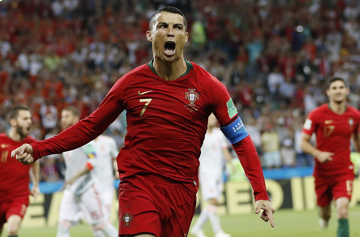

In [7]:
example = dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

让我们检查它对应的描述文本：

In [8]:
example["text"]

'Ronaldo with Portugal at the 2018 World Cup'

## 创建MindSpore数据集

接下来，我们创建一个标准的[Mindspore数据集]。数据集的每个项目返回模型所需的输入，在这种情况下是`input_ids`、`attention_mask`和`pixel_values`。

我们使用`GitProcessor`将每个（图像，文本）对转换为所需的输入。基本上，文本被转换为`input_ids`和`attention_mask`，而图像被转换为`pixel_values`。


In [9]:
class ImageCaptioningDataset:
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor
        
        self.encoded_inputs_list = []
        self.__get_encoded_inputs_list__()
    
    def __get_encoded_inputs_list__(self):
        for idx in range(self.__len__()):
            item = self.dataset[idx]
            
            encoding = self.processor(images=item["image"], text=item["text"], 
                                     padding="max_length", return_tensors="np")
            
            # 移除批次维度
            encoding = {k:v.squeeze() for k,v in encoding.items()}
            
            # 将字典值转换为元组，以便与MindSpore数据集兼容
            self.encoded_inputs_list.append(tuple(encoding.values()))
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        # 直接返回预处理好的数据
        return self.encoded_inputs_list[idx]

In [10]:
from mindnlp.transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/git-base-coco")

/home/ma-user/anaconda3/envs/python-3.10.0/lib/python3.10/site-packages/mindnlp/transformers/tokenization_utils_base.py:1526: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted, and will be then set to `False` by default. 
  warnings.warn(


In [11]:
processor

GitProcessor:
- image_processor: CLIPImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_center_crop",
    "crop_size",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "do_convert_rgb",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "GitProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

- tokenizer: BertTokenizerFast(name_or_path='microsoft/git-base-coco', vocab_size=30522, model_max_length=512, is_fast=True, paddi

In [12]:
train_dataset = ImageCaptioningDataset(dataset, processor)

让我们检查数据集的一个例子：

In [13]:
encoded_inputs = train_dataset[0]

In [14]:
col_names = ['input_ids', 'attention_mask', 'pixel_values']

In [15]:
for k,v in zip(col_names, encoded_inputs):
    print(k, v.shape, v.dtype)

input_ids (512,) int64
attention_mask (512,) int64
pixel_values (3, 224, 224) float32


## 创建MindSpore DataLoader

接下来，我们创建一个相应的MindSpore DataLoader，它允许我们从数据集中获取数据批次。

我们需要这个，因为神经网络（如GIT）是在数据批次上进行训练的，使用随机梯度下降（SGD）方法。


In [16]:
print(processor.tokenizer.decode(encoded_inputs[0]))

[CLS] ronaldo with portugal at the 2018 world cup [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [17]:
from mindspore.dataset import GeneratorDataset

train_dataloader = GeneratorDataset(train_dataset, shuffle=True, column_names=col_names)

In [18]:
batch_size = 2
train_dataloader = train_dataloader.batch(batch_size)
train_dataloader.get_col_names()

['input_ids', 'attention_mask', 'pixel_values']

In [19]:
dict_iterator0 = train_dataloader.create_dict_iterator()
datas = next(dict_iterator0)
for k,v in datas.items():
    print(k, v.shape, v.dtype)

input_ids (2, 512) mindspore.int64
attention_mask (2, 512) mindspore.int64
pixel_values (2, 3, 224, 224) mindspore.float32


让我们检查一个批次，并进行一些合理性检查。例如，我们可以将input_ids解码回文本：

In [20]:
processor.decode(datas["input_ids"][0])

[MS_ALLOC_CONF]Runtime config:  enable_vmm:True  vmm_align_size:2MB


'[CLS] pirlo with juventus in 2014 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

我们可以“去归一化”像素值以恢复图像：

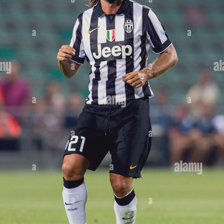

In [21]:
from PIL import Image
import numpy as np

MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (datas["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

看起来不错！检查你的数据总是很重要 ;) 有关训练神经网络时的提示，请参阅这篇[博客](http://karpathy.github.io/2019/04/25/recipe/) ，其中提供了很好的概述。

## 定义模型

接下来，我们实例化一个模型。我们从预训练的GIT-base模型开始（该模型已经由微软在400万对图像-文本上进行了预训练）。

当然，您也可以从[模型库](https://huggingface.co/models?other=git)开始微调其他GIT模型。


In [22]:
from mindnlp.transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-coco")

GitForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`.`PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


## 虚拟前向传播

检查批次上的初始损失总是很好的做法。请参阅上面的博客。


In [23]:
outputs = model(input_ids=datas["input_ids"],
                attention_mask=datas["attention_mask"],
                pixel_values=datas["pixel_values"],
                labels=datas["input_ids"])
outputs.loss

Tensor(shape=[], dtype=Float32, value= 12.2571)

## 训练模型

接下来，让我们训练模型！我们在这里使用原生的MindSpore。

由于我创建了一个非常小的数据集仅用于演示目的，我们将让模型过拟合这个数据集。如果它能够过拟合（即达到零损失），那么这就是确认一切正常工作的好方法。请参阅上面的博客。


In [28]:
from mindnlp.core.optim import AdamW
optimizer = AdamW(model.trainable_params(), lr =5e-5)

global_step = 0
num_train_epochs = 50

In [29]:
model.train()

GitForCausalLM(
  (git): GitModel(
    (embeddings): GitEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (image_encoder): GitVisionModel(
      (vision_model): GitVisionTransformer(
        (embeddings): GitVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
          (position_embedding): Embedding(197, 768)
        )
        (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (encoder): GitVisionEncoder(
          (layers): ModuleList(
            (0-11): 12 x GitVisionEncoderLayer(
              (self_attn): GitVisionAttention(
                (k_proj): Linear (768 -> 768)
                (v_proj): Linear (768 -> 768)
                (q_proj): Linear (768 -> 768)
                (out_proj): Linea

In [30]:
from mindnlp.core.autograd import value_and_grad

def forward_fn(batch):
    # get the inputs;
    input_ids = batch['input_ids']
    pixel_values=batch["pixel_values"]
    attention_mask = batch["attention_mask"] 
    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    attention_mask=attention_mask,
                    labels=input_ids) 
    loss = outputs.loss
    
    return loss

grad_fn = value_and_grad(forward_fn, model.trainable_params(), attach_grads=True)

In [31]:
from tqdm import tqdm

# put the model in training mode
model.set_train(True)

for epoch in range(num_train_epochs):  
    print("Epoch:", epoch)
    for batch in tqdm(train_dataloader.create_dict_iterator()):
        optimizer.zero_grad()
        # forward, backward + optimize
        loss = grad_fn(batch)
        optimizer.step()
        # print loss every 1 steps
        if global_step % 1 == 0:
            print(f"Loss after {global_step} steps: {loss.item()}")

        global_step += 1

Epoch: 0


1it [00:30, 30.28s/it]

Loss after 0 steps: 9.065927505493164


2it [01:01, 31.02s/it]

Loss after 1 steps: 8.42495059967041


3it [01:31, 30.53s/it]


Loss after 2 steps: 8.293713569641113
Epoch: 1


1it [00:30, 30.36s/it]

Loss after 3 steps: 8.16295337677002


2it [00:59, 29.85s/it]

Loss after 4 steps: 8.013680458068848


3it [01:30, 30.11s/it]


Loss after 5 steps: 7.883572578430176
Epoch: 2


1it [00:30, 30.42s/it]

Loss after 6 steps: 7.807605266571045


2it [01:00, 30.23s/it]

Loss after 7 steps: 7.67081356048584


3it [01:30, 30.20s/it]


Loss after 8 steps: 7.571207523345947
Epoch: 3


1it [00:30, 30.57s/it]

Loss after 9 steps: 7.463897228240967


2it [01:00, 30.29s/it]

Loss after 10 steps: 7.354569911956787


3it [01:30, 30.32s/it]


Loss after 11 steps: 7.251770496368408
Epoch: 4


1it [00:29, 29.94s/it]

Loss after 12 steps: 7.140876293182373


2it [00:59, 29.75s/it]

Loss after 13 steps: 7.0416154861450195


3it [01:29, 29.85s/it]


Loss after 14 steps: 6.911705017089844
Epoch: 5


1it [00:30, 30.78s/it]

Loss after 15 steps: 6.817172050476074


2it [01:01, 30.59s/it]

Loss after 16 steps: 6.7176666259765625


3it [01:30, 30.30s/it]


Loss after 17 steps: 6.586129188537598
Epoch: 6


1it [00:31, 31.13s/it]

Loss after 18 steps: 6.488780975341797


2it [01:00, 30.36s/it]

Loss after 19 steps: 6.357933044433594


3it [01:31, 30.36s/it]


Loss after 20 steps: 6.283557415008545
Epoch: 7


1it [00:30, 30.10s/it]

Loss after 21 steps: 6.177975654602051


2it [01:00, 30.55s/it]

Loss after 22 steps: 6.05144739151001


3it [01:31, 30.48s/it]


Loss after 23 steps: 5.909559726715088
Epoch: 8


1it [00:30, 30.39s/it]

Loss after 24 steps: 5.832393169403076


2it [01:00, 30.35s/it]

Loss after 25 steps: 5.6827311515808105


3it [01:31, 30.38s/it]


Loss after 26 steps: 5.628084659576416
Epoch: 9


1it [00:29, 29.89s/it]

Loss after 27 steps: 5.523305892944336


2it [01:00, 30.26s/it]

Loss after 28 steps: 5.40615177154541


3it [01:30, 30.12s/it]


Loss after 29 steps: 5.213799476623535
Epoch: 10


1it [00:30, 30.53s/it]

Loss after 30 steps: 5.169363498687744


2it [01:00, 30.26s/it]

Loss after 31 steps: 5.011143207550049


3it [01:30, 30.24s/it]


Loss after 32 steps: 4.951472282409668
Epoch: 11


1it [00:30, 30.42s/it]

Loss after 33 steps: 4.818099498748779


2it [01:00, 30.19s/it]

Loss after 34 steps: 4.752132892608643


3it [01:30, 30.14s/it]


Loss after 35 steps: 4.556360244750977
Epoch: 12


1it [00:29, 29.84s/it]

Loss after 36 steps: 4.49650239944458


2it [00:59, 30.01s/it]

Loss after 37 steps: 4.385390281677246


3it [01:29, 29.77s/it]


Loss after 38 steps: 4.21909761428833
Epoch: 13


1it [00:29, 29.53s/it]

Loss after 39 steps: 4.173262596130371


2it [00:59, 29.99s/it]

Loss after 40 steps: 3.970686435699463


3it [01:30, 30.14s/it]


Loss after 41 steps: 3.927945613861084
Epoch: 14


1it [00:30, 30.57s/it]

Loss after 42 steps: 3.8027923107147217


2it [01:01, 30.72s/it]

Loss after 43 steps: 3.6822011470794678


3it [01:32, 30.72s/it]


Loss after 44 steps: 3.568167209625244
Epoch: 15


1it [00:30, 30.95s/it]

Loss after 45 steps: 3.4331910610198975


2it [01:01, 30.68s/it]

Loss after 46 steps: 3.3472073078155518


3it [01:31, 30.56s/it]


Loss after 47 steps: 3.260338544845581
Epoch: 16


1it [00:30, 30.64s/it]

Loss after 48 steps: 3.154568672180176


2it [01:00, 30.47s/it]

Loss after 49 steps: 2.9715402126312256


3it [01:32, 30.75s/it]


Loss after 50 steps: 2.9153964519500732
Epoch: 17


1it [00:30, 30.68s/it]

Loss after 51 steps: 2.751758575439453


2it [01:01, 30.68s/it]

Loss after 52 steps: 2.6899890899658203


3it [01:31, 30.56s/it]


Loss after 53 steps: 2.6060171127319336
Epoch: 18


1it [00:30, 30.23s/it]

Loss after 54 steps: 2.490290403366089


2it [01:00, 30.08s/it]

Loss after 55 steps: 2.343986988067627


3it [01:30, 30.05s/it]


Loss after 56 steps: 2.2664201259613037
Epoch: 19


1it [00:29, 29.36s/it]

Loss after 57 steps: 2.161087989807129


2it [00:59, 29.60s/it]

Loss after 58 steps: 2.0345327854156494


3it [01:28, 29.64s/it]


Loss after 59 steps: 1.9782453775405884
Epoch: 20


1it [00:30, 30.45s/it]

Loss after 60 steps: 1.8602498769760132


2it [01:00, 29.98s/it]

Loss after 61 steps: 1.7491786479949951


3it [01:30, 30.00s/it]


Loss after 62 steps: 1.6942145824432373
Epoch: 21


1it [00:30, 30.35s/it]

Loss after 63 steps: 1.5747621059417725


2it [01:00, 30.12s/it]

Loss after 64 steps: 1.5204015970230103


3it [01:30, 30.22s/it]


Loss after 65 steps: 1.3968783617019653
Epoch: 22


1it [00:30, 30.37s/it]

Loss after 66 steps: 1.3227033615112305


2it [00:59, 29.73s/it]

Loss after 67 steps: 1.2513078451156616


3it [01:29, 29.82s/it]


Loss after 68 steps: 1.187151312828064
Epoch: 23


1it [00:29, 29.90s/it]

Loss after 69 steps: 1.0969479084014893


2it [01:00, 30.20s/it]

Loss after 70 steps: 1.059956431388855


3it [01:30, 30.14s/it]


Loss after 71 steps: 0.9577573537826538
Epoch: 24


1it [00:30, 30.75s/it]

Loss after 72 steps: 0.8961775898933411


2it [01:00, 30.04s/it]

Loss after 73 steps: 0.8707252144813538


3it [01:29, 29.98s/it]


Loss after 74 steps: 0.795368492603302
Epoch: 25


1it [00:29, 29.73s/it]

Loss after 75 steps: 0.7439081072807312


2it [01:00, 30.14s/it]

Loss after 76 steps: 0.6877240538597107


3it [01:29, 29.80s/it]


Loss after 77 steps: 0.6718136668205261
Epoch: 26


1it [00:30, 30.87s/it]

Loss after 78 steps: 0.6024844646453857


2it [01:00, 30.22s/it]

Loss after 79 steps: 0.567859411239624


3it [01:31, 30.57s/it]


Loss after 80 steps: 0.5508196949958801
Epoch: 27


1it [00:29, 29.90s/it]

Loss after 81 steps: 0.4999481737613678


2it [01:00, 30.27s/it]

Loss after 82 steps: 0.46543067693710327


3it [01:30, 30.21s/it]


Loss after 83 steps: 0.45984041690826416
Epoch: 28


1it [00:30, 30.13s/it]

Loss after 84 steps: 0.40757259726524353


2it [01:00, 30.52s/it]

Loss after 85 steps: 0.38844114542007446


3it [01:31, 30.48s/it]


Loss after 86 steps: 0.3843059539794922
Epoch: 29


1it [00:30, 30.05s/it]

Loss after 87 steps: 0.34499475359916687


2it [00:59, 29.91s/it]

Loss after 88 steps: 0.3223034143447876


3it [01:30, 30.03s/it]


Loss after 89 steps: 0.32699814438819885
Epoch: 30


1it [00:29, 29.96s/it]

Loss after 90 steps: 0.2884945273399353


2it [01:00, 30.03s/it]

Loss after 91 steps: 0.2929944097995758


3it [01:30, 30.06s/it]


Loss after 92 steps: 0.2648010551929474
Epoch: 31


1it [00:29, 29.86s/it]

Loss after 93 steps: 0.250153511762619


2it [00:59, 29.80s/it]

Loss after 94 steps: 0.2383788824081421


3it [01:29, 29.97s/it]


Loss after 95 steps: 0.24277131259441376
Epoch: 32


1it [00:30, 30.44s/it]

Loss after 96 steps: 0.21519970893859863


2it [01:01, 30.78s/it]

Loss after 97 steps: 0.22285735607147217


3it [01:32, 30.68s/it]


Loss after 98 steps: 0.20001204311847687
Epoch: 33


1it [00:29, 29.71s/it]

Loss after 99 steps: 0.18993787467479706


2it [00:59, 29.81s/it]

Loss after 100 steps: 0.18304461240768433


3it [01:30, 30.24s/it]


Loss after 101 steps: 0.19094929099082947
Epoch: 34


1it [00:29, 29.60s/it]

Loss after 102 steps: 0.16915741562843323


2it [01:00, 30.43s/it]

Loss after 103 steps: 0.1631990522146225


3it [01:30, 30.27s/it]


Loss after 104 steps: 0.17212523519992828
Epoch: 35


1it [00:29, 29.79s/it]

Loss after 105 steps: 0.16475757956504822


2it [01:00, 30.10s/it]

Loss after 106 steps: 0.14825625717639923


3it [01:30, 30.03s/it]


Loss after 107 steps: 0.14253731071949005
Epoch: 36


1it [00:30, 30.01s/it]

Loss after 108 steps: 0.13726414740085602


2it [01:00, 30.09s/it]

Loss after 109 steps: 0.14647693932056427


3it [01:29, 29.89s/it]


Loss after 110 steps: 0.13168631494045258
Epoch: 37


1it [00:30, 30.08s/it]

Loss after 111 steps: 0.1392091065645218


2it [01:00, 30.22s/it]

Loss after 112 steps: 0.12249387055635452


3it [01:30, 30.20s/it]


Loss after 113 steps: 0.12037944793701172
Epoch: 38


1it [00:30, 30.32s/it]

Loss after 114 steps: 0.1167619377374649


2it [01:00, 30.00s/it]

Loss after 115 steps: 0.11530955880880356


3it [01:31, 30.44s/it]


Loss after 116 steps: 0.12134409695863724
Epoch: 39


1it [00:30, 30.27s/it]

Loss after 117 steps: 0.1170339435338974


2it [01:00, 30.06s/it]

Loss after 118 steps: 0.1207583025097847


3it [01:29, 29.99s/it]


Loss after 119 steps: 0.10606683045625687
Epoch: 40


1it [00:30, 30.12s/it]

Loss after 120 steps: 0.10028679668903351


2it [01:00, 30.04s/it]

Loss after 121 steps: 0.10101254284381866


3it [01:30, 30.08s/it]


Loss after 122 steps: 0.11029678583145142
Epoch: 41


1it [00:30, 30.66s/it]

Loss after 123 steps: 0.09850713610649109


2it [01:00, 30.38s/it]

Loss after 124 steps: 0.10272006690502167


3it [01:31, 30.52s/it]


Loss after 125 steps: 0.09320767968893051
Epoch: 42


1it [00:29, 29.46s/it]

Loss after 126 steps: 0.09350321441888809


2it [00:59, 29.64s/it]

Loss after 127 steps: 0.08805336803197861


3it [01:28, 29.62s/it]


Loss after 128 steps: 0.09742731600999832
Epoch: 43


1it [00:29, 29.50s/it]

Loss after 129 steps: 0.09334572404623032


2it [00:59, 30.04s/it]

Loss after 130 steps: 0.08327750116586685


3it [01:30, 30.11s/it]


Loss after 131 steps: 0.08235760033130646
Epoch: 44


1it [00:30, 30.11s/it]

Loss after 132 steps: 0.07984835654497147


2it [01:00, 30.19s/it]

Loss after 133 steps: 0.08805875480175018


3it [01:30, 30.14s/it]


Loss after 134 steps: 0.07692563533782959
Epoch: 45


1it [00:29, 29.90s/it]

Loss after 135 steps: 0.07646998763084412


2it [01:00, 30.28s/it]

Loss after 136 steps: 0.07494240254163742


3it [01:30, 30.13s/it]


Loss after 137 steps: 0.07985523343086243
Epoch: 46


1it [00:30, 30.42s/it]

Loss after 138 steps: 0.07317690551280975


2it [01:00, 29.98s/it]

Loss after 139 steps: 0.07707379758358002


3it [01:29, 29.86s/it]


Loss after 140 steps: 0.06948451697826385
Epoch: 47


1it [00:30, 30.19s/it]

Loss after 141 steps: 0.07507594674825668


2it [01:00, 30.42s/it]

Loss after 142 steps: 0.06733966618776321


3it [01:30, 30.26s/it]


Loss after 143 steps: 0.06727617233991623
Epoch: 48


1it [00:31, 31.10s/it]

Loss after 144 steps: 0.06549022346735


2it [01:00, 30.20s/it]

Loss after 145 steps: 0.0637931376695633


3it [01:30, 30.09s/it]


Loss after 146 steps: 0.07028262317180634
Epoch: 49


1it [00:30, 30.03s/it]

Loss after 147 steps: 0.06266003102064133


2it [01:00, 30.15s/it]

Loss after 148 steps: 0.06806033104658127


3it [01:30, 30.12s/it]

Loss after 149 steps: 0.06014471873641014


## 推理

现在我们已经训练了模型，让我们加载马拉多纳的图像并对其进行推理。


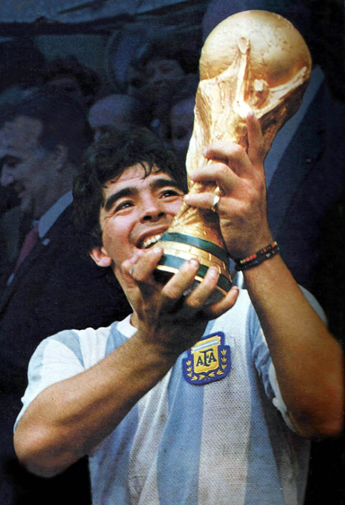

In [33]:
# load image
example = dataset[3]
image = example["image"]
width, height = image.size
display(image.resize((int(0.9*width), int(0.9*height))))

In [37]:
inputs = processor(images=image, return_tensors="ms")
pixel_values = inputs.pixel_values
generated_ids = model.generate(pixel_values=pixel_values, max_length=80)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

maradona after winning the 1986 fifa world cup with argentina


太好了！我们已经成功地在我们的小型（图像，文本）数据集上微调了GIT，以生成足球运动员图像的描述。